---

# Project: Amazon Product Recommendation System

## Introduction

Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 


### Context

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

### Objective

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.
- Knowledge/Rank Based Recommendation System
- Similarity-Based Collaborative Filtering
- Matrix Factorization Based Collaborative Filtering

### Data Description

The Amazon dataset contains the following attributes

- user_id: Every user identified with a unique id
- prod_Id: Every product identified with a unique id
- rating: The rating of the corresponding product by the corresponding user
- timestamp: Time of the rating. We **will not use this column** to solve the current problem

---

## Importing Necessary Libraries and Data

This section sets up the environment by importing tools for data manipulation, visualization, handling special characters, and conducting statistical analysis

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# ----------------------------------------------------------------------
# Utility Libraries for Directory and File Handling
# ----------------------------------------------------------------------

# import copy  # For deep copying objects
import pickle  # For serializing and saving Python objects
import sys  # For managing system paths
import time  # For tracking execution time
import warnings  # For suppressing warnings

# Start timer
start_time = time.time()

# Suppress warnings
warnings.filterwarnings("ignore")

# Add the parent directory to the system path to access custom modules
sys.path.append("../")

In [ ]:
# ----------------------------------------------------------------------
# Libraries for Data Manipulation, and Visualization
# ----------------------------------------------------------------------

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

%matplotlib inline

# Jupyter notebook display utilities
from IPython.display import Markdown, display

# ----------------------------------------------------------------------
# Surprise Library for Recommender Systems
# ----------------------------------------------------------------------

# Data loading, parsing and splitting
from surprise.dataset import Dataset
from surprise.reader import Reader # (user ; item ; rating structure)
from surprise.model_selection import train_test_split

# Similarity-based and matrix factorization-based algorithms
from surprise.prediction_algorithms import (
    SVD,
    KNNBaseline,
    KNNBasic,
    KNNWithMeans,
    KNNWithZScore,
    SVDpp,
)


In [ ]:
# ----------------------------------------------------------------------
# Import Modules for Recommendation Systems
# ----------------------------------------------------------------------

# Import classes for recommendation systems
from src.cf_recommender import CFRecommendationSystem
from src.hybrid_recommender import HybridRecommendationSystem
from src.rank_recommender import RankRecommendationSystem

In [ ]:
# ----------------------------------------------------------------------
# Import Modules for EDA
# ----------------------------------------------------------------------

# Import functions for exploratory data analysis, model evaluation, and utilities
from src.eda_functions import (
    barplot,
    barplot_subplots,
    palette_color,
    plot_interaction_boxplot,
    plot_interaction_histplot,
)
from src.model_eval_functions import baseline_gs
from src.utils import (
    prepare_and_display_metrics,
    read_all_csv_files,
    select_interactions,
)

---

## Loading Data

This section involves reading the dataset from a CSV file into a pandas DataFrame for further analysis.

In [5]:
# Read the DataFrame | Single File
# raw_data = pd.read_csv("../data/raw/ratings_Electronics.csv", header=None)

# Read the DataFrame | Multiple Files (due to GitHub repo file size limit)
folder_path = "../data/raw"
raw_data = read_all_csv_files(folder_path=folder_path, header=None)

**Reading CSV Files**

Imported: ../data/raw/amazon_product_ratings_part_1.csv
Imported: ../data/raw/amazon_product_ratings_part_2.csv
Imported: ../data/raw/amazon_product_ratings_part_3.csv
Imported: ../data/raw/amazon_product_ratings_part_4.csv
Imported: ../data/raw/amazon_product_ratings_part_5.csv
Imported: ../data/raw/amazon_product_ratings_part_6.csv
Imported: ../data/raw/amazon_product_ratings_part_7.csv
Imported: ../data/raw/amazon_product_ratings_part_8.csv
Imported: ../data/raw/amazon_product_ratings_part_9.csv
Imported: ../data/raw/amazon_product_ratings_part_10.csv
Imported: ../data/raw/amazon_product_ratings_part_11.csv
Imported: ../data/raw/amazon_product_ratings_part_12.csv
Imported: ../data/raw/amazon_product_ratings_part_13.csv

Data import successful. Total files read: 13


In [6]:
# Add column names
raw_data.columns = ["user_id", "prod_id", "rating", "timestamp"]

# Drop colum 'timestamp'
raw_data = raw_data.drop("timestamp", axis=1)

# Create copy of the DataFrame
df = raw_data.copy(deep=True)

# Check number of rows and columns in the dataset
df.shape

(7824494, 3)

## Data Preprocessing

Given the dataset's vast size of 7.8 million observations and the sparsity in user and product ratings, an initial approach was taken to reduce the dataset by filtering for users with at least 50 ratings and products with at least 5 ratings.

However, this approach led to a recursive loop issue, where the filtered dataset caused some users to no longer meet the rating threshold, leading to continuous data loss. To resolve this, a balanced filtering strategy was implemented, gradually adjusting thresholds with convergence checks to stabilize the dataset size, ensuring that significant data was retained without excessive reduction.

In [7]:
# Define initial thresholds
user_threshold = 25
product_threshold = 5

# Define maximum threshold increments for iterative filtering
max_user_threshold = 50
max_product_threshold = 10

# Set convergence flag and initial dataset size
converged = False
prev_size = df.shape[0]

In [8]:
# Initial filtering with low thresholds
user_ratings_count = df["user_id"].value_counts()
df = df[
    df["user_id"].isin(user_ratings_count[user_ratings_count >= user_threshold].index)
]

product_ratings_count = df["prod_id"].value_counts()
df = df[
    df["prod_id"].isin(
        product_ratings_count[product_ratings_count >= product_threshold].index
    )
]

# Set initial values for convergence check
prev_size = df.shape[0]
converged = False

while not converged:
    # Increment thresholds gradually
    if user_threshold < max_user_threshold:
        user_threshold += 5  # Increase user threshold incrementally
    if product_threshold < max_product_threshold:
        product_threshold += 1  # Increase product threshold incrementally

    # Filter users with at least the current user threshold ratings
    user_ratings_count = df["user_id"].value_counts()
    df = df[
        df["user_id"].isin(
            user_ratings_count[user_ratings_count >= user_threshold].index
        )
    ]

    # Filter products with at least the current product threshold ratings
    product_ratings_count = df["prod_id"].value_counts()
    df = df[
        df["prod_id"].isin(
            product_ratings_count[product_ratings_count >= product_threshold].index
        )
    ]

    # Check the current size of the dataset
    current_size = df.shape[0]

    # Check for convergence: if the dataset size decreases significantly, stop iterating
    if abs(prev_size - current_size) > 10000:  # Adjust this value as needed
        converged = True
    else:
        prev_size = current_size

    # If thresholds have reached maximum but no significant change, break to avoid infinite loop
    if (
        user_threshold >= max_user_threshold
        and product_threshold >= max_product_threshold
    ):
        print("Reached maximum thresholds without significant change. Stopping.")
        break

# Final thresholds applied
print(f"user_threshold: {user_threshold}")
print(f"product_threshold: {product_threshold}")

user_threshold: 30
product_threshold: 6


In [9]:
# Reset index of dataset
df.reset_index(drop=True, inplace=True)

## Data Overview

This section provides a high-level summary of the DataFrame, including the dimensions, data types, and an initial look at the first and last few rows. It checks for duplicate records and counts the unique values for each feature, confirming data integrity and providing an overview of the dataset’s structure.

### High-Level Data Information

In [10]:
# Number of rows and columns
df.shape

(78798, 3)

In [11]:
# First 5 rows
df.head()

,user_id,prod_id,rating
0,A3BMUBUC1N77U8,0972683275,4.0
1,A6J8D9V5S9MBE,0972683275,5.0
2,A3CLWR1UUZT6TG,0972683275,5.0
3,A3TAS1AG6FMBQW,0972683275,5.0
4,ABU4LUKJU2QOY,0972683275,5.0


In [12]:
# Last 5 rows
df.tail()

,user_id,prod_id,rating
78793,A3S3R88HA0HZG3,B00L3YHF6O,5.0
78794,A26VF18X91983P,B00L3YHF6O,5.0
78795,A2XRMQA6PJ5ZJ8,B00L3YHF6O,5.0
78796,A3A4ZAIBQWKOZS,B00L3YHF6O,5.0
78797,AOVTLYTHVDNUX,B00L3YHF6O,5.0


In [13]:
# Summary of DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78798 entries, 0 to 78797
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  78798 non-null  object 
 1   prod_id  78798 non-null  object 
 2   rating   78798 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.8+ MB


**Observations:**
- The DataFrame has **131,109 observations and 3 columns**.
- Data types include object and float64.
- No missing values, as row counts match non-null counts for each column.
- One column is numerical, the others are categorical or textual.

### Unique and Duplicate Values

In [14]:
# Number of duplicate rows
dvalues = df.duplicated().sum()

# Convert into DataFrame
duplicate_df = pd.DataFrame({"metric": ["duplicate_rows"], "count": [dvalues]})

# Display DataFrame
duplicate_df

,metric,count
0,duplicate_rows,0


In [15]:
# Number of unique values per feature
nuniq = df.nunique().reset_index()

# Rename column names
nuniq.columns = ["feature", "unique values"]

# Display DataFrame
nuniq

,feature,unique values
0,user_id,1992
1,prod_id,5402
2,rating,5


**Observations**:
- **Duplicate Records**: The dataset is free of duplicate entries, ensuring the integrity of the data.
- **User and Product Data:** There are **2,964 users** and **14,571 products**.
- **Rating Data:** A total of **43,188,444** possible ratings, the dataset includes only 131,109 ratings, resulting in a sparse dataset for the recommendation system, as not every user has rated every product.
- **Additional Details:** More insights and specifics are provided in the subsequent sections.

### Export of Processed Data

In [16]:
# Define the export path and filename for the processed and cleaned dataset
processed_data_filename = "../data/processed/processed_data.pkl"

# Export the dataset
with open(processed_data_filename, "wb") as f:
    pickle.dump(df, f)

# Print status log
print(f"Dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Processed data exported successfully to '{processed_data_filename}'")

Dimensions: 78798 rows, 3 columns
Processed data exported successfully to '../data/processed/processed_data.pkl'


## Exploratory Data Analysis

### Statistical Analysis of DataFrame

In [17]:
# Select categorical and numerical columns
cat_cols = list(df.select_dtypes(include=["object"]).columns)
num_cols = list(df.select_dtypes(include=[np.number]).columns)

#### Analysis of Numerical Data

In [18]:
# Statistical summary of numerical data
df[num_cols].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
rating,78798.0,4.28,0.99,1.0,4.0,5.0,5.0,5.0


**Observations**:
- **rating**: There are 131,109 unique ratings. The data is skewed towards higher values, with a mean of 4.29 and the majority of ratings at 5.0, indicating that most users rate their experiences positively.

#### Analysis of Categorical Data

In [19]:
# Statistical summary of categorical data
df[cat_cols].describe().T

,count,unique,top,freq
user_id,78798,1992,ADLVFFE4VBT8,283
prod_id,78798,5402,B0088CJT4U,276


**Observations**:
- **user_id**: There are 2,964 unique users, with the most active user having rated 360 products.
- **prod_id**: There are 14,571 unique products, with the most frequently rated product receiving 302 ratings.

### Univariate Analysis of Numerical Columns
For analysis purposes, the 'rating' column, consisting of discrete numbers from 1 to 5, will be treated as a categorical variable. This approach allows us to effectively observe its distribution and patterns.

#### Column | rating

Rating Distribution
------------------------------
 rating  percentage
    1.0        2.72
    2.0        3.95
    3.0       10.46
    4.0       28.63
    5.0       54.24
------------------------------


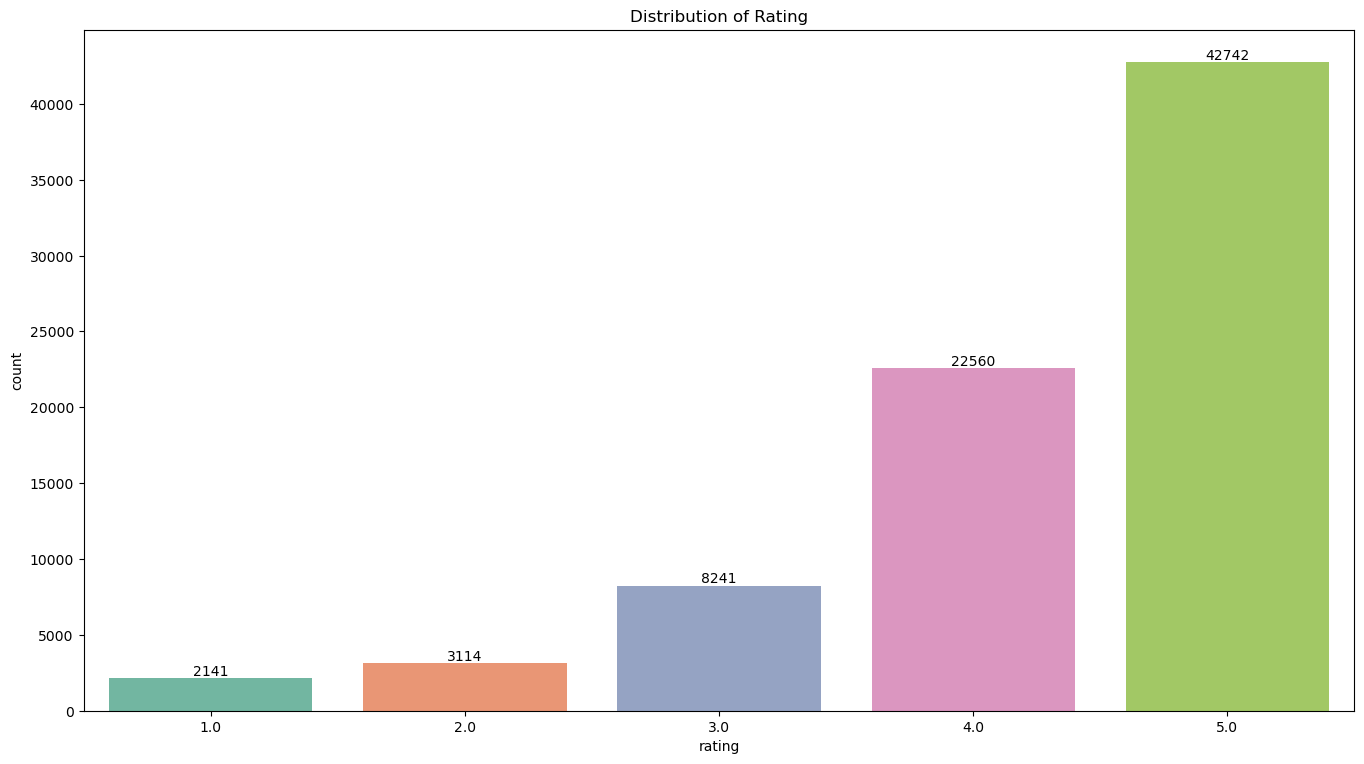

Mean: 4.28, Median: 5.0


In [20]:
# Visualizing the distribution of the feature 'rating' and relative percentage annotations
barplot(df, "rating", perc=False)

**Observations**:
- **High Ratings Dominance**: The majority of ratings are high, with 56.93% being 5.0 and 26.08% at 4.0, indicating a strong bias toward positive feedback.
- **Low Ratings Rarity**: Low ratings (1.0 and 2.0) are rare, accounting for only 3.35% and 4.01% of the ratings, respectively.
- **Left-Skewed Distribution**: The distribution is left-skewed, with the mean (4.29) being lower than the median (5.0).

### Univariate Analysis of Categorical Columns

#### Column | user_id, prod_id

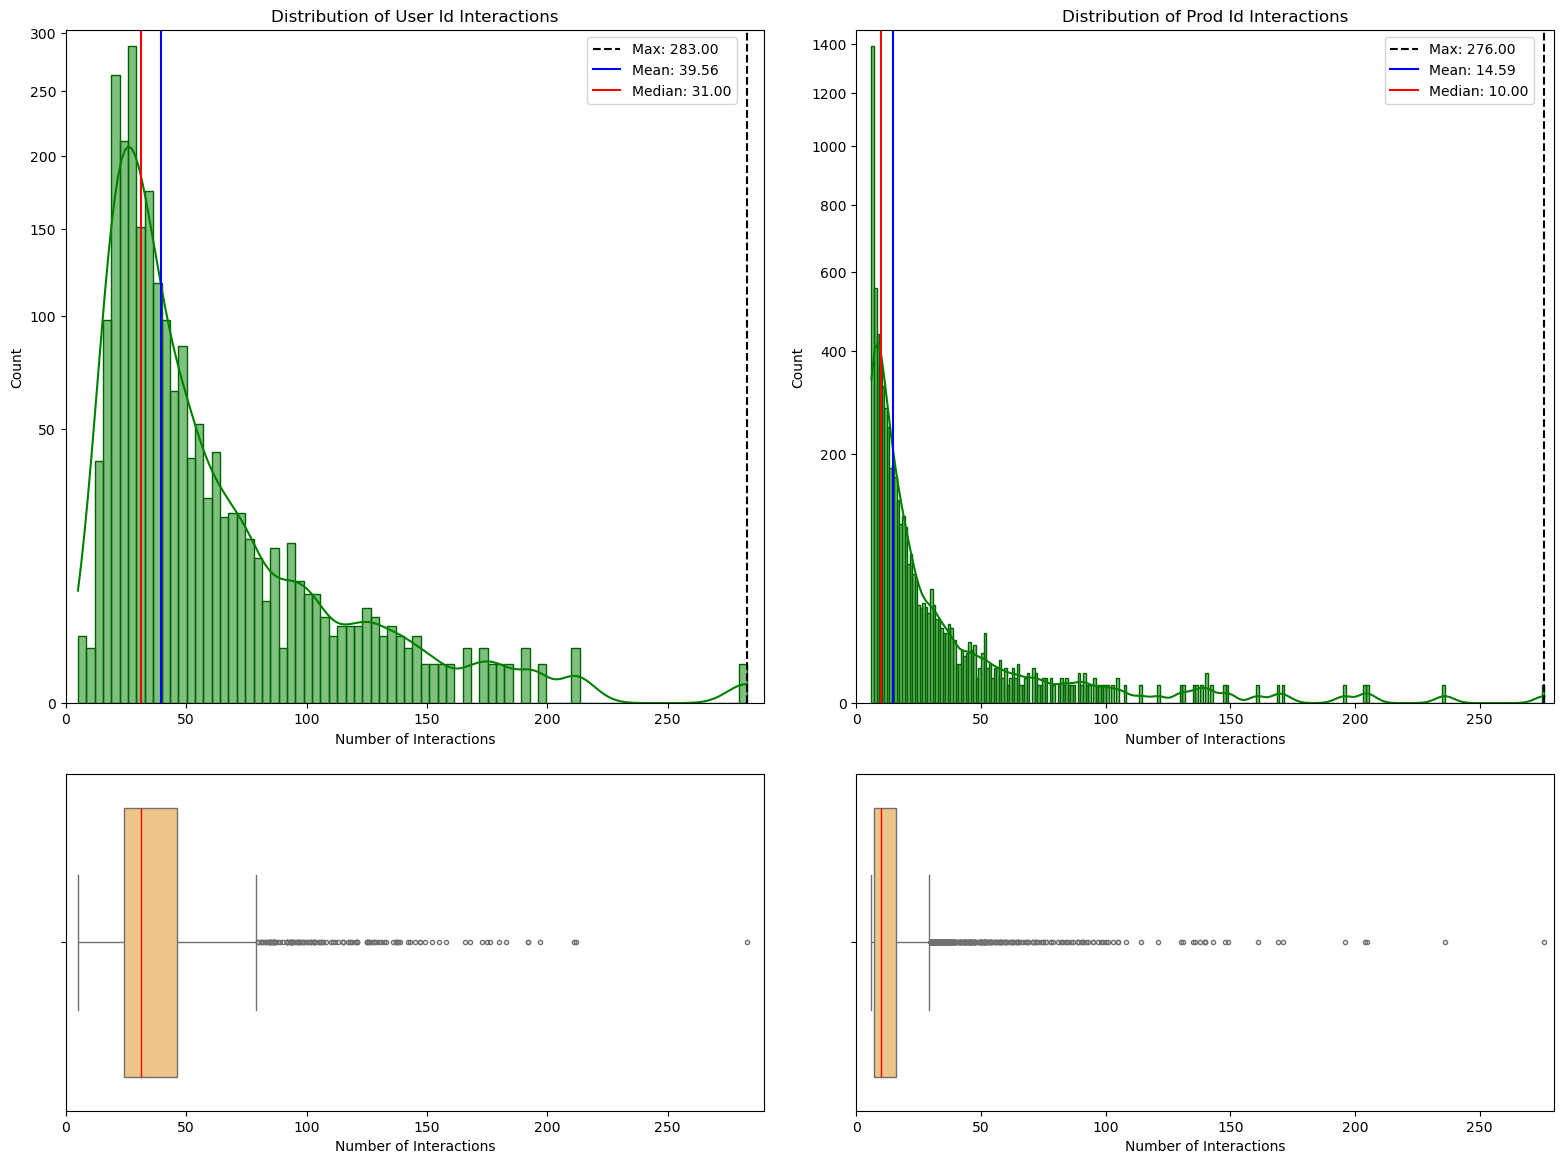

In [21]:
# Note: Histplot y-axis is scaled by square root

# Create a combined figure with GridSpec
fig = plt.figure(figsize=(16, 12))
gs = GridSpec(2, 2, height_ratios=[2, 1])

# Plotting user-product interactions distribution (histplot)
ax0 = fig.add_subplot(gs[0, 0])
plot_interaction_histplot(df, "user_id", "prod_id", ax0)

# Plotting product-user interactions distribution (histplot)
ax1 = fig.add_subplot(gs[0, 1])
plot_interaction_histplot(df, "prod_id", "user_id", ax1)

# Plotting user-product interactions distribution (boxplot)
ax2 = fig.add_subplot(gs[1, 0])
plot_interaction_boxplot(df, "user_id", "prod_id", ax2)

# Plotting product-user interactions distribution (boxplot)
ax3 = fig.add_subplot(gs[1, 1])
plot_interaction_boxplot(df, "prod_id", "user_id", ax3)

# Synchronize x-axis limits for boxplots
ax2.set_xlim(ax0.get_xlim()[0], ax0.get_xlim()[1])
ax3.set_xlim(ax0.get_xlim()[0], ax1.get_xlim()[1])

plt.tight_layout(pad=2.0)
plt.show()

**Observations**:

- **Skewed Distribution**: Both user-product and product-user interactions show a right-skewed distribution, with most interactions being on the lower end.
- **Low Interaction Dominance**: The majority of users interact with a small number of products (10 to 50 interactions), and most products are interacted with by a small number of users (1 to 10 interactions).
- **Presence of Outliers**: There are notable outliers, with the maximum interactions for a single user reaching 360 and for a single product reaching 302, significantly higher than the mean and median, indicating that very few products and users dominate the interaction counts.

#### Column | user_id

Top 10 Entries
------------------------------
       user_id  count
  ADLVFFE4VBT8    283
A3OXHLG6DIBRW8    212
A1ODOGXEYECQQ8    211
A36K2N527TXXJN    197
A25C2M3QF9G7OQ    192
 A680RUE1FDO8B    192
A1UQBFCERIP7VJ    183
 AWPODHOB4GFWL    180
A22CW0ZHY3NJH8    176
 AGVWTYW0ULXHT    175
------------------------------


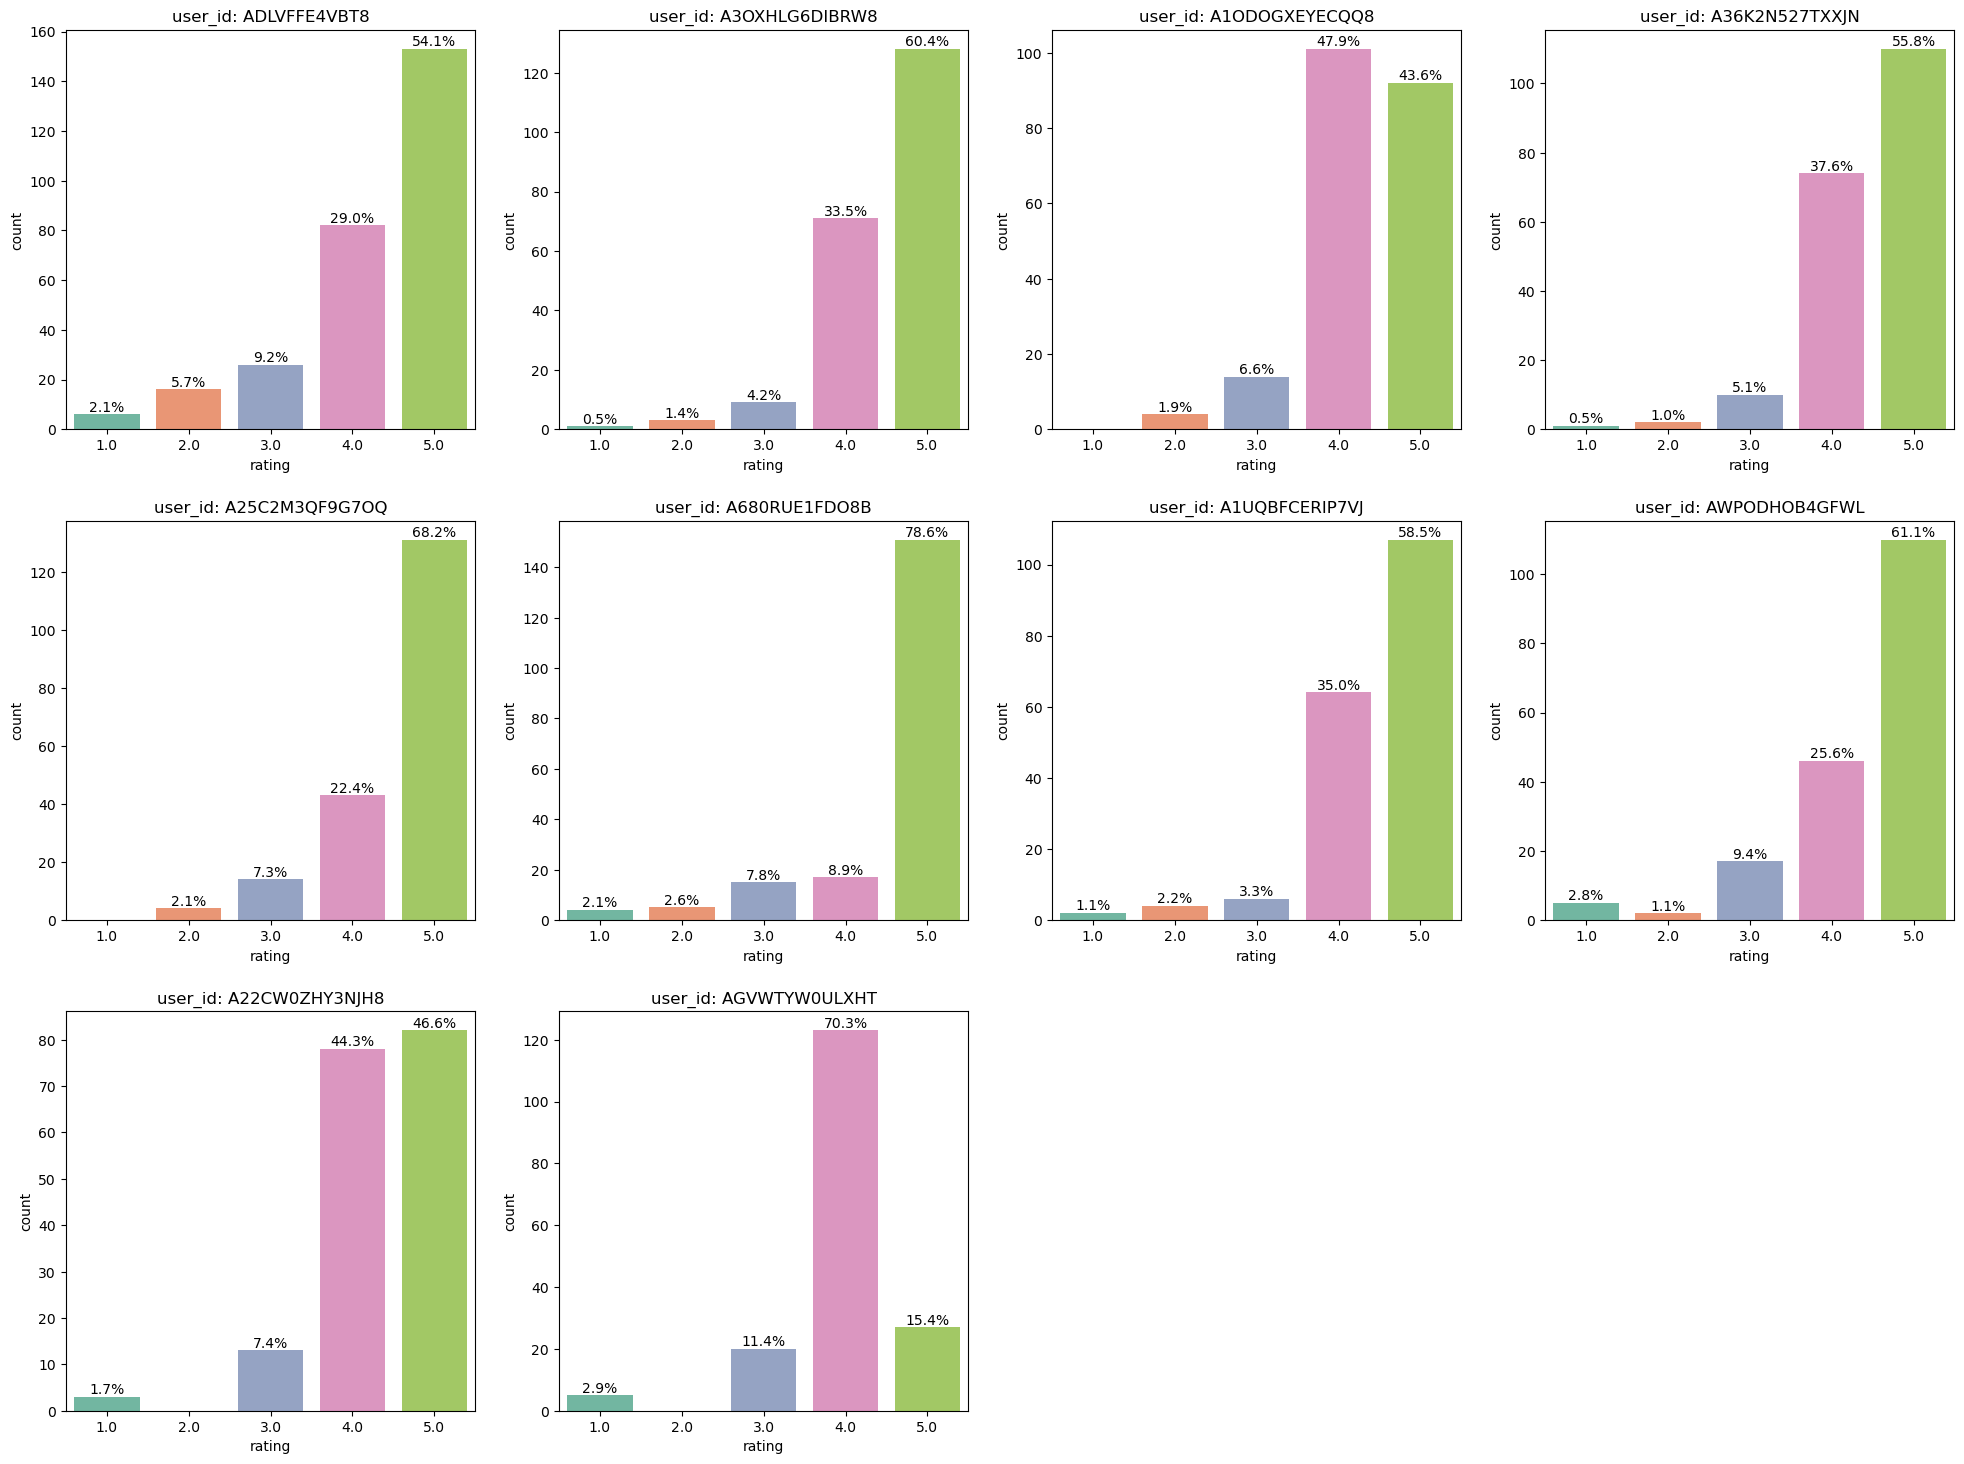

In [22]:
# Visualizing the rating distribution for the top 10 users based on the total number of ratings
features = ["user_id", "rating"]
barplot_subplots(df, features, perc=True)

**Observations**:
- **High User Engagement**: The most active user, 'ADLVFFE4VBT8', has 360 interactions, with other top users ranging from 240 to 320 interactions, indicating significant engagement from a small subset of users.
- **Positive Rating Dominance**: The majority of top users consistently favor 5-star ratings, with percentages between 46.3% and 77.3%, reflecting a strong tendency toward positive feedback.
- **Diverse and Consistent Rating Behavior**: While most users predominantly give 5-star ratings, some, like 'ADLVFFE4VBT8', 'AWPODHOB4GFWL' and 'A5JLAU2ARJ0BO', show a more varied rating distribution with significant 3-star and 4-star ratings, suggesting varying levels of satisfaction or rating behavior among the most active users.
- **Rare Negative Ratings**: Low ratings (1 and 2 stars) are infrequent among the top 10 users, averaging 2.14% and 3.51% respectively, indicating generally positive experiences or a reluctance to rate poorly.

#### Column | prod_id

Top 10 Entries
------------------------------
   prod_id  count
B0088CJT4U    276
B003ES5ZUU    236
B00829TIEK    205
B007WTAJTO    204
B000N99BBC    196
B008DWCRQW    171
B00829THK0    169
B00829TIA4    161
B00834SJSK    149
B002R5AM7C    148
------------------------------


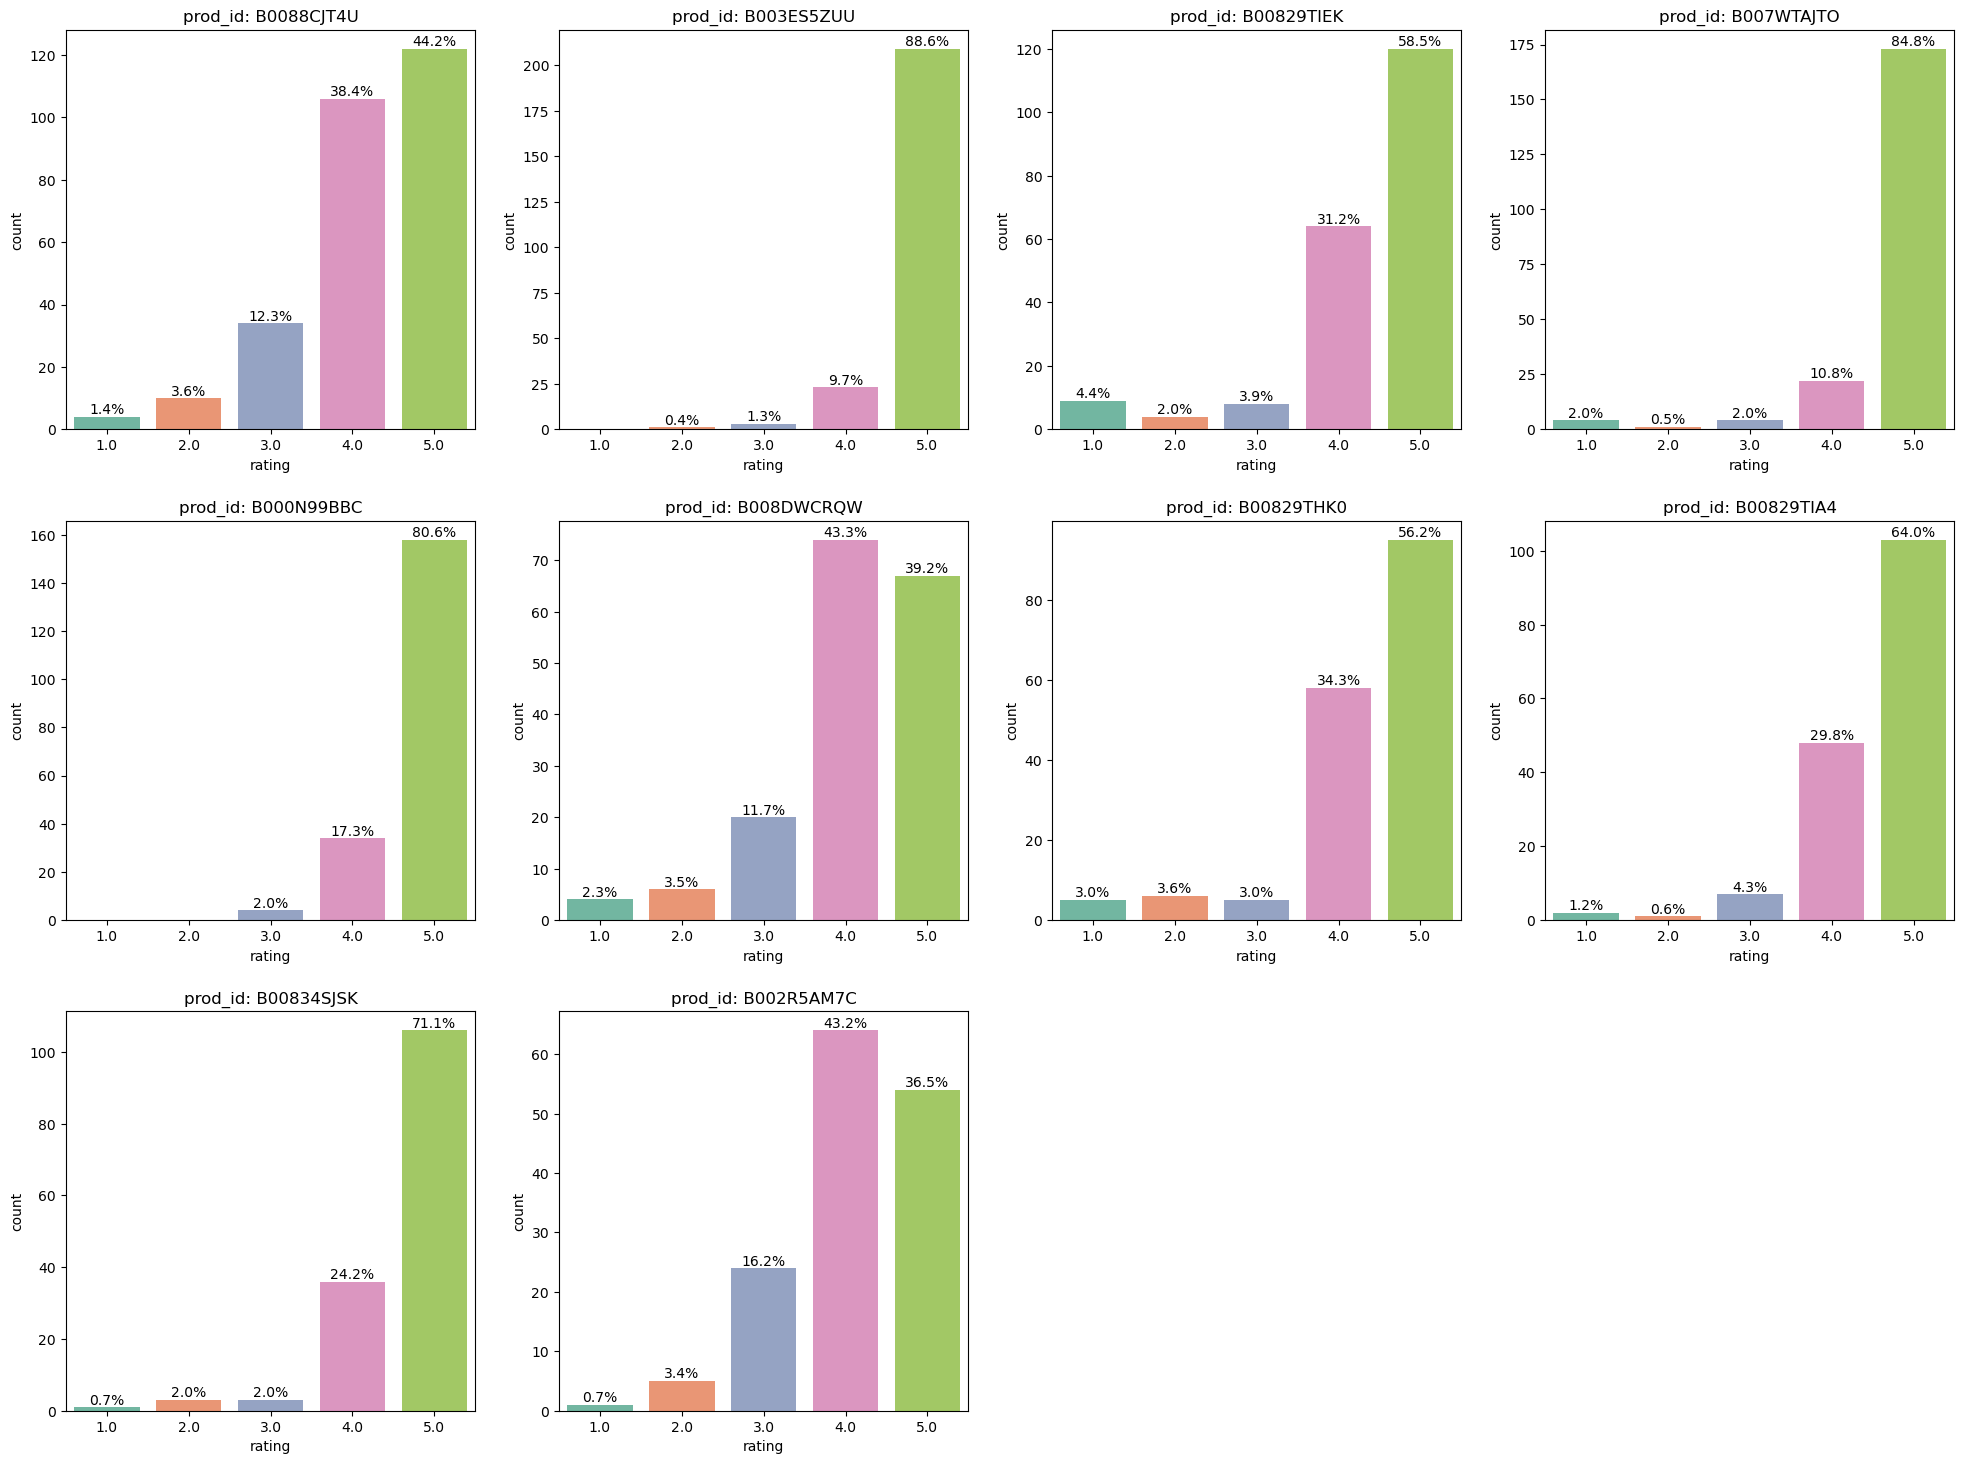

In [23]:
# Visualizing the rating distribution for the top 10 products based on the total number of ratings
features = ["prod_id", "rating"]
barplot_subplots(df, features, perc=True)

**Observations**:
- **Top Products by Interaction**: The most frequently rated product, 'B0088CJT4U', has 302 ratings, with others in the top 10 ranging from 290 to 175 ratings, indicating significant engagement with a small subset of products.
- **Positive Rating Dominance**: The majority of the top products exhibit a strong tendency toward 5-star ratings, with percentages ranging from 45.0% to 88.3%. This reflects a generally positive feedback pattern.
- **Diverse Rating Behavior**: While high ratings are dominant, products like 'B008DWCRQW', 'B00829TIEK', and 'B0088CJT4U' display a wider spread across different rating levels, with notable proportions of 3-star and 4-star ratings, indicating more varied customer experiences.
- **Low Frequency of Negative Ratings**: Across these top 10 products, ratings of 1 and 2 stars are rare, averaging around 1.84% and 2.27% respectively, suggesting generally positive experiences or a reluctance to rate products poorly.

## Model Preparation and Setup

### Data Preprocessing

Loading the **rating dataset**, a pandas DataFrame, into a different format called **'surprise.dataset.DatasetAutoFolds'**, which is required by the 'surprise' library. This process uses the **'Reader' and 'Dataset' classes**.

In [24]:
# Instantiate Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Load the rating dataset
data = Dataset.load_from_df(df[["user_id", "prod_id", "rating"]], reader=reader)

# Split the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Randomly select user IDs and retrieve their interacted and non-interacted products
user_interactions, user_non_interactions = select_interactions(
    trainset, num_users=2, num_products=2
)

**User Interactions**

{'A1GNYV0RA0EQSS': [('B005TDWX2Q', 5.0), ('B00DQZP7X6', 5.0)],
 'A2AY4YUOX2N1BQ': [('B0077CR5RK', 5.0), ('B0033PRWSW', 5.0)]}

**User Non-Interactions**

{'A1GNYV0RA0EQSS': ['B005VTIMEQ', 'B00JP7R7DC'],
 'A2AY4YUOX2N1BQ': ['B0049CPQ36', 'B0009MZ9UA']}

### Initialization of Key Parameters for Model Evaluation

In [26]:
# Top-K recommendations for evaluation (Precision@K, Recall@K, etc.)
k = 10

# Rating threshold for recommendation relevance
threshold = 4.5  # Increased due to hugh volume of high ratings

# Cross validation iterator
cviter = 6

## Model 1: Rank Based Recommendation System

A rank-based recommendation system provides recommendations based on the most popular items. This approach is useful for addressing cold start problems, where new users lack historical interactions. In such cases, the system can recommend popular items to new users without relying on past data.

The **Bayesian Average** enhances the reliability of a product’s rating by considering both the global average rating and the number of ratings a product has received. This method reduces the impact of small sample sizes, ensuring fairer recommendations by preventing products with few ratings from being overly favored or penalized.

$$\text{Bayesian Avg.} = \frac{\bar{R} \times k + \sum R}{k + N}$$

where:
- $\bar{R}$ is the global average rating.
- $k$ is the regularization parameter (often set to the average number of ratings across items).
- $\sum R$ is the sum of ratings for the specific item.
- $N$ is the number of ratings for the specific item.

### Baseline Model

In [ ]:
# Initialize the rank-based recommendation system using Bayesian average scoring
model_rank = RankRecommendationSystem(method="bayesian")

# Compute scores for products using the chosen rank-based method
model_rank.compute_scores(data=df, gb_feature="prod_id", filter_feature="rating")

In [ ]:
# Evaluate the rank-based model
model_rank_metric = model_rank.evaluate(
    trainset=trainset, testset=testset, k=k, th=threshold
)

In [ ]:
# Generate top-N product recommendations ranked by the Bayesian average score
model_rank.recommend(top_n=5, threshold=0)

In [ ]:
# Generate top-N product recommendations, with at least 100 user-item interactions, ranked by the Bayesian average score
model_rank.recommend(top_n=5, threshold=100)

**Observations**:
- The rank-based recommendation system identifies the top 10 products from the prepared dataset, utilizing the Bayesian average to balance popularity with the number of interactions. Additionally, the system refines the rankings by considering products with at least 50 interactions, ensuring a more robust and fair product ranking.

## Model 2: User-User Collaborative Filtering Recommendation System

### Baseline Model

In [30]:
# Common base parameter grid for most k-NN algorithms
base_knn_param_grid = {
    "k": [10, 20, 30],  # Number of nearest neighbor
    "min_k": [3, 5, 7],  # Minimum number of nearest neighbor
    "sim_options": {
        "name": ["cosine", "msd", "pearson"],
        "user_based": [True],
    },
}

# Specific parameter grid for KNNBaseline algorithm
knn_baseline_param_grid = {
    **base_knn_param_grid,  # Use the base grid and extend it
    "sim_options": {
        "name": ["cosine", "msd", "pearson", "pearson_baseline"],
        "user_based": [True],
    },
}

# Combine all parameter grids into one dictionary
knn_param_grids = {
    "KNNBasic": base_knn_param_grid,
    "KNNWithMeans": base_knn_param_grid,
    "KNNWithZScore": base_knn_param_grid,
    "KNNBaseline": knn_baseline_param_grid,
}


# Combine the parameter grids into a dictionary
knn_algorithms = {
    "KNNBasic": KNNBasic,
    "KNNWithMeans": KNNWithMeans,
    "KNNWithZScore": KNNWithZScore,
    "KNNBaseline": KNNBaseline,
}

# Run grid search for all k-NN algorithms
knn_baseline_name, knn_baseline_params = baseline_gs(
    data, knn_algorithms, knn_param_grids, cv=cviter
)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearso

**KNNBasic:**

RMSE: 0.952
Parameters: {'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


**KNNWithMeans:**

RMSE: 0.912
Parameters: {'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


**KNNWithZScore:**

RMSE: 0.912
Parameters: {'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': True}}


**KNNBaseline:**

RMSE: 0.888
Parameters: {'k': 30, 'min_k': 7, 'sim_options': {'name': 'pearson', 'user_based': True}}


**------------------------------ BASELINE MODEL SELECTION: KNNBaseline -------------------------------**

In [31]:
# Select the k-Nearest Neighbors (kNN) algorithm and corresponding parameter grid
model = knn_algorithms[knn_baseline_name]
params_grid = knn_baseline_params

# Initialize the baseline recommendation system
model_uu = CFRecommendationSystem(data=data, algo_class=model, params_grid=params_grid)

In [32]:
# Train the model
model_uu.fit_knn(trainset=trainset, use_tuned_params=False)

# Evaluate the model's performance
model_uu_metric = model_uu.evaluate(
    trainset=trainset, testset=testset, k=k, th=threshold
)

Parameters: {'k': 30, 'min_k': 7, 'sim_options': {'name': 'pearson', 'user_based': True}, 'random_state': 42, 'verbose': False}


**Predictive Quality Metrics**

,Trainset,Testset
RMSE,0.789,0.890
Precision@K,0.774,0.500
Recall@K,0.318,0.338
F1 Score@K,0.451,0.403


**Ranking Quality Metrics**

,Trainset,Testset
MRR,0.942,0.812
MAP,0.883,0.757
Hit Rate@K,0.995,0.943


In [33]:
# Perform cross-validation
model_uu.cross_val(data=data, measures=["rmse", "mae"], cv=cviter)

Evaluating RMSE, MAE of algorithm KNNBaseline on 6 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Mean    Std     
RMSE (testset)    0.8831  0.8962  0.8943  0.9004  0.8875  0.8735  0.8892  0.0090  
MAE (testset)     0.6618  0.6657  0.6642  0.6659  0.6660  0.6549  0.6631  0.0039  
Fit time          0.14    0.15    0.14    0.14    0.12    0.11    0.13    0.01    
Test time         0.19    0.15    0.15    0.15    0.14    0.13    0.15    0.02    


In [34]:
# Predict ratings for interacted and non-interacted products
model_uu.predict(int_data=user_interactions, has_interacted=True)
model_uu.predict(int_data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A1GNYV0RA0EQSS item: B005TDWX2Q r_ui = 5.00   est = 4.37   {'actual_k': 2, 'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00DQZP7X6 r_ui = 5.00   est = 4.25   {'actual_k': 2, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0077CR5RK r_ui = 5.00   est = 4.60   {'actual_k': 1, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0033PRWSW r_ui = 5.00   est = 4.85   {'actual_k': 3, 'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A1GNYV0RA0EQSS item: B005VTIMEQ r_ui = None   est = 3.84   {'actual_k': 0, 'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00JP7R7DC r_ui = None   est = 4.24   {'actual_k': 0, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0049CPQ36 r_ui = None   est = 4.32   {'actual_k': 0, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0009MZ9UA r_ui = None   est = 4.36   {'actual_k': 0, 'was_impossible': False}


### Tuned Model

In [35]:
# Extract similarity names based on algorithm
sim_names = (
    ["cosine", "msd", "pearson", "pearson_baseline"]
    if "Baseline" in knn_baseline_name
    else ["cosine", "msd", "pearson"]
)

# Prepare the parameter grid for hyperparameter tuning
param_grid = {
    "k": [32, 33, 34],
    "min_k": [12, 13, 14],
    "sim_options": {
        "name": sim_names,
        "user_based": [True],
    },
}

# Display the parameter grid for reference
display(Markdown("**Hyperparameter Tuning Grid**"))
display(param_grid)

# Tune the hyperparameters using the specified grid
model_uu.tune_hyperparameters(param_grid=param_grid, measures=["rmse"], cv=cviter)

**Hyperparameter Tuning Grid**

{'k': [32, 33, 34],
 'min_k': [12, 13, 14],
 'sim_options': {'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
  'user_based': [True]}}

Estimating biases using als...
Estimating biases using als...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Estimating biases using als...
Estimating biases using als...
Done computing sim

In [36]:
# Train the model
model_uu.fit_knn(trainset=trainset, use_tuned_params=True)

# Evaluate the model's performance
model_uu_opt_metric = model_uu.evaluate(
    trainset=trainset, testset=testset, k=k, th=threshold
)

Parameters: {'k': 32, 'min_k': 14, 'sim_options': {'name': 'pearson', 'user_based': True}, 'random_state': 42, 'verbose': False}


**Predictive Quality Metrics**

,Trainset,Testset
RMSE,0.820,0.888
Precision@K,0.724,0.496
Recall@K,0.292,0.336
F1 Score@K,0.416,0.401


**Ranking Quality Metrics**

,Trainset,Testset
MRR,0.927,0.813
MAP,0.864,0.757
Hit Rate@K,0.995,0.943


In [37]:
# Perform cross-validation
model_uu.cross_val(data=data, measures=["rmse", "mae"], cv=cviter)

Evaluating RMSE, MAE of algorithm KNNBaseline on 6 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Mean    Std     
RMSE (testset)    0.8953  0.8812  0.8850  0.8924  0.8763  0.8943  0.8874  0.0071  
MAE (testset)     0.6667  0.6592  0.6629  0.6636  0.6571  0.6656  0.6625  0.0034  
Fit time          0.12    0.13    0.13    0.13    0.12    0.11    0.12    0.01    
Test time         0.15    0.15    0.16    0.14    0.14    0.14    0.15    0.01    


In [38]:
# Predict ratings for interacted and non-interacted products
model_uu.predict(int_data=user_interactions, has_interacted=True)
model_uu.predict(int_data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A1GNYV0RA0EQSS item: B005TDWX2Q r_ui = 5.00   est = 4.37   {'actual_k': 2, 'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00DQZP7X6 r_ui = 5.00   est = 4.25   {'actual_k': 2, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0077CR5RK r_ui = 5.00   est = 4.60   {'actual_k': 1, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0033PRWSW r_ui = 5.00   est = 4.85   {'actual_k': 3, 'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A1GNYV0RA0EQSS item: B005VTIMEQ r_ui = None   est = 3.84   {'actual_k': 0, 'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00JP7R7DC r_ui = None   est = 4.24   {'actual_k': 0, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0049CPQ36 r_ui = None   est = 4.32   {'actual_k': 0, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0009MZ9UA r_ui = None   est = 4.36   {'actual_k': 0, 'was_impossible': False}


In [39]:
# Get the top 5 recommendations for user IDs
model_uu.recommend(data=df, int_data=user_interactions, top_n=5)

**Recommendations for User: A1GNYV0RA0EQSS**

,prod_id,estimated_ratings,details
0,B0052SCU8U,4.77,"{'actual_k': 1, 'was_impossible': False}"
1,B00BQ4F9ZA,4.76,"{'actual_k': 0, 'was_impossible': False}"
2,B0000BZL1P,4.75,"{'actual_k': 0, 'was_impossible': False}"
3,B001TH7GUU,4.74,"{'actual_k': 0, 'was_impossible': False}"
4,B000N99BBC,4.73,"{'actual_k': 4, 'was_impossible': False}"


**Recommendations for User: A2AY4YUOX2N1BQ**

,prod_id,estimated_ratings,details
0,B0052SCU8U,4.98,"{'actual_k': 1, 'was_impossible': False}"
1,B00BQ4F9ZA,4.96,"{'actual_k': 1, 'was_impossible': False}"
2,B0000BZL1P,4.96,"{'actual_k': 1, 'was_impossible': False}"
3,B001TH7GUU,4.95,"{'actual_k': 3, 'was_impossible': False}"
4,B000N99BBC,4.93,"{'actual_k': 1, 'was_impossible': False}"


## Model 3: Item-Item Collaborative Filtering Recommendation System

### Baseline Model

In [40]:
# Common base parameter grid for most k-NN algorithms
base_knn_param_grid = {
    "k": [10, 20, 30],  # Number of nearest neighbor
    "min_k": [3, 5, 7],  # Minimum number of nearest neighbor
    "sim_options": {
        "name": ["cosine", "msd", "pearson"],
        "user_based": [False],
    },
}

# Specific parameter grid for KNNBaseline algorithm
knn_baseline_param_grid = {
    **base_knn_param_grid,  # Use the base grid and extend it
    "sim_options": {
        "name": ["cosine", "msd", "pearson", "pearson_baseline"],
        "user_based": [False],
    },
}

# Combine all parameter grids into one dictionary
knn_param_grids = {
    "KNNBasic": base_knn_param_grid,
    "KNNWithMeans": base_knn_param_grid,
    "KNNWithZScore": base_knn_param_grid,
    "KNNBaseline": knn_baseline_param_grid,
}


# Combine the parameter grids into a dictionary
knn_algorithms = {
    "KNNBasic": KNNBasic,
    "KNNWithMeans": KNNWithMeans,
    "KNNWithZScore": KNNWithZScore,
    "KNNBaseline": KNNBaseline,
}

# Run grid search for all k-NN algorithms
knn_baseline_name, knn_baseline_params = baseline_gs(
    data, knn_algorithms, knn_param_grids, cv=cviter
)

Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearso

**KNNBasic:**

RMSE: 0.963
Parameters: {'k': 30, 'min_k': 7, 'sim_options': {'name': 'msd', 'user_based': False}}


**KNNWithMeans:**

RMSE: 0.926
Parameters: {'k': 30, 'min_k': 5, 'sim_options': {'name': 'cosine', 'user_based': False}}


**KNNWithZScore:**

RMSE: 0.928
Parameters: {'k': 30, 'min_k': 7, 'sim_options': {'name': 'cosine', 'user_based': False}}


**KNNBaseline:**

RMSE: 0.889
Parameters: {'k': 30, 'min_k': 7, 'sim_options': {'name': 'pearson', 'user_based': False}}


**------------------------------ BASELINE MODEL SELECTION: KNNBaseline -------------------------------**

In [41]:
# Select the k-Nearest Neighbors (kNN) algorithm and corresponding parameter grid
model = knn_algorithms[knn_baseline_name]
params_grid = knn_baseline_params

# Initialize the baseline recommendation system
model_ii = CFRecommendationSystem(data=data, algo_class=model, params_grid=params_grid)

In [42]:
# Train the model
model_ii.fit_knn(trainset=trainset, use_tuned_params=False)

# Evaluate the model's performance
model_ii_metric = model_ii.evaluate(
    trainset=trainset, testset=testset, k=k, th=threshold
)

Parameters: {'k': 30, 'min_k': 7, 'sim_options': {'name': 'pearson', 'user_based': False}, 'random_state': 42, 'verbose': False}


**Predictive Quality Metrics**

,Trainset,Testset
RMSE,0.787,0.889
Precision@K,0.735,0.493
Recall@K,0.297,0.336
F1 Score@K,0.423,0.400


**Ranking Quality Metrics**

,Trainset,Testset
MRR,0.942,0.811
MAP,0.887,0.756
Hit Rate@K,0.996,0.943


In [43]:
# Perform cross-validation
model_ii.cross_val(data=data, measures=["rmse", "mae"], cv=cviter)

Evaluating RMSE, MAE of algorithm KNNBaseline on 6 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Mean    Std     
RMSE (testset)    0.8906  0.8769  0.8925  0.9011  0.8863  0.8810  0.8881  0.0079  
MAE (testset)     0.6660  0.6564  0.6630  0.6690  0.6608  0.6591  0.6624  0.0042  
Fit time          2.20    2.16    1.73    2.24    2.11    1.86    2.05    0.19    
Test time         0.29    0.29    0.38    0.25    0.25    0.27    0.29    0.04    


In [44]:
# Predict ratings for interacted and non-interacted products
model_ii.predict(int_data=user_interactions, has_interacted=True)
model_ii.predict(int_data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A1GNYV0RA0EQSS item: B005TDWX2Q r_ui = 5.00   est = 4.37   {'actual_k': 2, 'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00DQZP7X6 r_ui = 5.00   est = 4.25   {'actual_k': 3, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0077CR5RK r_ui = 5.00   est = 4.60   {'actual_k': 1, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0033PRWSW r_ui = 5.00   est = 4.85   {'actual_k': 1, 'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A1GNYV0RA0EQSS item: B005VTIMEQ r_ui = None   est = 3.84   {'actual_k': 0, 'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00JP7R7DC r_ui = None   est = 4.24   {'actual_k': 0, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0049CPQ36 r_ui = None   est = 4.32   {'actual_k': 1, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0009MZ9UA r_ui = None   est = 4.36   {'actual_k': 0, 'was_impossible': False}


### Tuned Model

In [45]:
# Extract similarity names based on algorithm
sim_names = (
    ["cosine", "msd", "pearson", "pearson_baseline"]
    if "Baseline" in knn_baseline_name
    else ["cosine", "msd", "pearson"]
)

# Prepare the parameter grid for hyperparameter tuning
param_grid = {
    "k": [34, 35, 36],
    "min_k": [13, 14, 15],
    "sim_options": {
        "name": sim_names,
        "user_based": [False],
    },
}

# Display the parameter grid for reference
display(Markdown("**Hyperparameter Tuning Grid**"))
display(param_grid)

# Tune the hyperparameters using the specified grid
model_ii.tune_hyperparameters(param_grid=param_grid, measures=["rmse"], cv=cviter)

**Hyperparameter Tuning Grid**

{'k': [34, 35, 36],
 'min_k': [13, 14, 15],
 'sim_options': {'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
  'user_based': [False]}}

Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Estimating biases using als...
Computing the msd similarity matrix...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Estimating biases using als...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Estimating biases using als...
Computing the

In [46]:
# Train the model
model_ii.fit_knn(trainset=trainset, use_tuned_params=True)

# Evaluate the model's performance
model_ii_opt_metric = model_ii.evaluate(
    trainset=trainset, testset=testset, k=k, th=threshold
)

Parameters: {'k': 36, 'min_k': 13, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}, 'random_state': 42, 'verbose': False}


**Predictive Quality Metrics**

,Trainset,Testset
RMSE,0.794,0.888
Precision@K,0.734,0.497
Recall@K,0.303,0.337
F1 Score@K,0.429,0.402


**Ranking Quality Metrics**

,Trainset,Testset
MRR,0.931,0.813
MAP,0.876,0.757
Hit Rate@K,0.995,0.943


In [47]:
# Perform cross-validation
model_ii.cross_val(data=data, measures=["rmse", "mae"], cv=cviter)

Evaluating RMSE, MAE of algorithm KNNBaseline on 6 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Mean    Std     
RMSE (testset)    0.8968  0.8738  0.8865  0.8923  0.8778  0.8964  0.8873  0.0089  
MAE (testset)     0.6667  0.6544  0.6603  0.6651  0.6563  0.6683  0.6618  0.0052  
Fit time          1.02    0.58    1.13    0.90    0.86    0.66    0.86    0.19    
Test time         0.30    0.32    0.27    0.27    0.27    0.27    0.28    0.02    


In [48]:
# Predict ratings for interacted and non-interacted products
model_ii.predict(int_data=user_interactions, has_interacted=True)
model_ii.predict(int_data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A1GNYV0RA0EQSS item: B005TDWX2Q r_ui = 5.00   est = 4.37   {'actual_k': 5, 'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00DQZP7X6 r_ui = 5.00   est = 4.25   {'actual_k': 6, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0077CR5RK r_ui = 5.00   est = 4.60   {'actual_k': 2, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0033PRWSW r_ui = 5.00   est = 4.85   {'actual_k': 6, 'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A1GNYV0RA0EQSS item: B005VTIMEQ r_ui = None   est = 3.84   {'actual_k': 0, 'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00JP7R7DC r_ui = None   est = 4.24   {'actual_k': 0, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0049CPQ36 r_ui = None   est = 4.32   {'actual_k': 1, 'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0009MZ9UA r_ui = None   est = 4.36   {'actual_k': 0, 'was_impossible': False}


In [49]:
# Get the top 5 recommendations for user IDs
model_ii.recommend(data=df, int_data=user_interactions, top_n=5)

**Recommendations for User: A1GNYV0RA0EQSS**

,prod_id,estimated_ratings,details
0,B0052SCU8U,4.77,"{'actual_k': 2, 'was_impossible': False}"
1,B00BQ4F9ZA,4.76,"{'actual_k': 0, 'was_impossible': False}"
2,B0000BZL1P,4.75,"{'actual_k': 2, 'was_impossible': False}"
3,B001TH7GUU,4.74,"{'actual_k': 0, 'was_impossible': False}"
4,B000N99BBC,4.73,"{'actual_k': 7, 'was_impossible': False}"


**Recommendations for User: A2AY4YUOX2N1BQ**

,prod_id,estimated_ratings,details
0,B003ES5ZUU,5.00,"{'actual_k': 14, 'was_impossible': False}"
1,B0052SCU8U,4.98,"{'actual_k': 3, 'was_impossible': False}"
2,B00BQ4F9ZA,4.96,"{'actual_k': 8, 'was_impossible': False}"
3,B0000BZL1P,4.96,"{'actual_k': 4, 'was_impossible': False}"
4,B001TH7GUU,4.95,"{'actual_k': 7, 'was_impossible': False}"


## Model 4: Model-Based Collaborative Filtering - Matrix Factorization

Model-based Collaborative Filtering is a **personalized recommendation system** that relies solely on user-item interaction data. It makes recommendations by decomposing the user-item interaction matrix into lower-dimensional matrices, capturing latent factors that represent user and item characteristics.

### Baseline Model

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [50]:
# Common base parameter grid for SVD algorithms
base_svd_param_grid = {
    "n_factors": [20, 30, 40],  # Numbers of latent factors
    "n_epochs": [30, 50, 70, 90],  # Numbers of epochs
    "lr_all": [0.003, 0.005, 0.007],  # Learning rates
    "reg_all": [0.05, 0.1, 0.2],  # Regularization rates
    "random_state": [42],  # Random state
}

# Combine all parameter grids into one dictionary for SVD algorithms
svd_param_grids = {
    "SVD": base_svd_param_grid,
    "SVD++": base_svd_param_grid,
}

# Dictionary of SVD algorithms
svd_algorithms = {
    "SVD": SVD,
    "SVD++": SVDpp,
}

# Run grid search for all SVD algorithms
svd_baseline_name, svd_baseline_params = baseline_gs(
    data, svd_algorithms, svd_param_grids, cv=cviter
)

**SVD:**

RMSE: 0.883
Parameters: {'n_epochs': 70, 'lr_all': 0.003, 'reg_all': 0.2, 'n_factors': 20}


**SVD++:**

RMSE: 0.884
Parameters: {'n_epochs': 70, 'lr_all': 0.003, 'reg_all': 0.2, 'n_factors': 20}


**---------------------------------- BASELINE MODEL SELECTION: SVD -----------------------------------**

In [51]:
# Select the Singular Value Decomposition (SVD) algorithm and corresponding parameter grid
model = svd_algorithms[svd_baseline_name]
params_grid = svd_baseline_params

# Initialize the baseline recommendation system
model_svd = CFRecommendationSystem(data=data, algo_class=model, params_grid=params_grid)

In [52]:
# Train the model
model_svd.fit_svd(trainset=trainset, use_tuned_params=False)

# Evaluate the model's performance
model_svd_metric = model_svd.evaluate(
    trainset=trainset, testset=testset, k=k, th=threshold
)

Parameters: {'n_factors': 20, 'n_epochs': 70, 'lr_all': 0.003, 'reg_all': 0.2, 'random_state': 42}


**Predictive Quality Metrics**

,Trainset,Testset
RMSE,0.780,0.883
Precision@K,0.726,0.518
Recall@K,0.337,0.399
F1 Score@K,0.460,0.451


**Ranking Quality Metrics**

,Trainset,Testset
MRR,0.953,0.810
MAP,0.891,0.756
Hit Rate@K,0.996,0.943


In [53]:
# Perform cross-validation
model_svd.cross_val(data=data, measures=["rmse", "mae"], cv=cviter)

Evaluating RMSE, MAE of algorithm SVD on 6 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Mean    Std     
RMSE (testset)    0.8846  0.8726  0.8910  0.8721  0.8974  0.8782  0.8827  0.0093  
MAE (testset)     0.6504  0.6431  0.6514  0.6434  0.6545  0.6485  0.6485  0.0041  
Fit time          0.35    0.35    0.35    0.35    0.35    0.35    0.35    0.00    
Test time         0.03    0.03    0.04    0.03    0.03    0.04    0.03    0.00    


In [54]:
# Predict ratings for interacted and non-interacted products
model_svd.predict(int_data=user_interactions, has_interacted=True)
model_svd.predict(int_data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A1GNYV0RA0EQSS item: B005TDWX2Q r_ui = 5.00   est = 4.49   {'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00DQZP7X6 r_ui = 5.00   est = 4.32   {'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0077CR5RK r_ui = 5.00   est = 4.69   {'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0033PRWSW r_ui = 5.00   est = 4.97   {'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A1GNYV0RA0EQSS item: B005VTIMEQ r_ui = None   est = 3.71   {'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00JP7R7DC r_ui = None   est = 4.28   {'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0049CPQ36 r_ui = None   est = 4.20   {'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0009MZ9UA r_ui = None   est = 4.30   {'was_impossible': False}


### Tuned Model

In [55]:
# Refined hyperparameter grid after extensive pre-screening
param_grid = {
    "n_factors": [19, 20, 21],  # Numbers of latent factors
    "n_epochs": [54, 55, 56],  # Numbers of epochs
    "lr_all": [0.0028, 0.0029, 0.003],  # Learning rates
    "reg_all": [0.22, 0.23, 0.24],  # Regularization rates
    "random_state": [42],  # Random state
}

# Display the parameter grid for reference
display(Markdown("**Hyperparameter Tuning Grid**"))
display(param_grid)

# Tune the hyperparameters using the specified grid
model_svd.tune_hyperparameters(param_grid=param_grid, measures=["rmse"], cv=cviter)

**Hyperparameter Tuning Grid**

{'n_epochs': [54, 55, 56],
 'lr_all': [0.0028, 0.0029, 0.003],
 'reg_all': [0.22, 0.23, 0.24],
 'n_factors': [19, 20, 21]}

RMSE: 0.883
Parameters: {'n_epochs': 55, 'lr_all': 0.003, 'reg_all': 0.22, 'n_factors': 20}


In [56]:
# Train the model
model_svd.fit_svd(trainset=trainset, use_tuned_params=True)

# Evaluate the model's performance
model_svd_opt_metric = model_svd.evaluate(
    trainset=trainset, testset=testset, k=k, th=threshold
)

Parameters: {'n_factors': 20, 'n_epochs': 55, 'lr_all': 0.003, 'reg_all': 0.22, 'random_state': 42}


**Predictive Quality Metrics**

,Trainset,Testset
RMSE,0.792,0.883
Precision@K,0.708,0.509
Recall@K,0.325,0.388
F1 Score@K,0.445,0.440


**Ranking Quality Metrics**

,Trainset,Testset
MRR,0.946,0.810
MAP,0.884,0.755
Hit Rate@K,0.996,0.943


In [57]:
# Perform cross-validation
model_svd.cross_val(data=data, measures=["rmse", "mae"], cv=cviter)

Evaluating RMSE, MAE of algorithm SVD on 6 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Mean    Std     
RMSE (testset)    0.8922  0.8763  0.8847  0.8736  0.8812  0.8897  0.8829  0.0067  
MAE (testset)     0.6578  0.6464  0.6500  0.6446  0.6501  0.6587  0.6513  0.0053  
Fit time          0.28    0.28    0.28    0.28    0.28    0.28    0.28    0.00    
Test time         0.03    0.03    0.03    0.03    0.04    0.03    0.03    0.00    


In [58]:
# Predict ratings for interacted and non-interacted products
model_svd.predict(int_data=user_interactions, has_interacted=True)
model_svd.predict(int_data=user_non_interactions, has_interacted=False)

**Rating Estimates for Interacted Products**

user: A1GNYV0RA0EQSS item: B005TDWX2Q r_ui = 5.00   est = 4.46   {'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00DQZP7X6 r_ui = 5.00   est = 4.30   {'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0077CR5RK r_ui = 5.00   est = 4.67   {'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0033PRWSW r_ui = 5.00   est = 4.94   {'was_impossible': False}


**Rating Estimates for Non-Interacted Products**

user: A1GNYV0RA0EQSS item: B005VTIMEQ r_ui = None   est = 3.71   {'was_impossible': False}
user: A1GNYV0RA0EQSS item: B00JP7R7DC r_ui = None   est = 4.26   {'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0049CPQ36 r_ui = None   est = 4.22   {'was_impossible': False}
user: A2AY4YUOX2N1BQ item: B0009MZ9UA r_ui = None   est = 4.31   {'was_impossible': False}


In [59]:
# Get the top 5 recommendations for user IDs
model_svd.recommend(data=df, int_data=user_interactions, top_n=5)

**Recommendations for User: A1GNYV0RA0EQSS**

,prod_id,estimated_ratings,details
0,B000JV9LUK,4.89,{'was_impossible': False}
1,B001FA09WI,4.83,{'was_impossible': False}
2,B00BW6KCTU,4.82,{'was_impossible': False}
3,B00IVPU6AA,4.81,{'was_impossible': False}
4,B0076W9Q5A,4.81,{'was_impossible': False}


**Recommendations for User: A2AY4YUOX2N1BQ**

,prod_id,estimated_ratings,details
0,B000JV9LUK,5.00,{'was_impossible': False}
1,B001FA09WI,5.00,{'was_impossible': False}
2,B0076W9Q5A,5.00,{'was_impossible': False}
3,B005ES0YYA,4.97,{'was_impossible': False}
4,B00IVPU6AA,4.97,{'was_impossible': False}


## Model 5: Hybrid Recommendation System

### Baseline

In [ ]:
# Initialize the hybrid recommendation system, combining CF and rank-based scores
model_hybrid = HybridRecommendationSystem(
    model_cf=model_svd,
    model_rank=model_rank,
    weight_cf=0.8,
    weight_rank=0.2,
)

In [ ]:
# Evaluate the model's performance
hybrid_metric = model_hybrid.evaluate(
    trainset=trainset,
    testset=testset,
    k=k,
    th=threshold,
)

In [ ]:
# Predict hybrid ratings for interacted products
model_hybrid.predict(int_data=user_interactions, has_interacted=True)

# Predict hybrid ratings for non-interacted products
model_hybrid.predict(int_data=user_non_interactions, has_interacted=False)

In [ ]:
# Get the top 5 recommendations for user IDs
model_hybrid.recommend(data=df, int_data=user_interactions, top_n=5)

## Model Comparison

In [60]:
# Define metric dictionaries
baseline_metrics = {
    "model_uu_train": model_uu_metric[0],
    "model_uu_test": model_uu_metric[1],
    "model_ii_train": model_ii_metric[0],
    "model_ii_test": model_ii_metric[1],
    "model_svd_train": model_svd_metric[0],
    "model_svd_test": model_svd_metric[1],
}

tuned_metrics = {
    "model_uu_train": model_uu_opt_metric[0],
    "model_uu_test": model_uu_opt_metric[1],
    "model_ii_train": model_ii_opt_metric[0],
    "model_ii_test": model_ii_opt_metric[1],
    "model_svd_train": model_svd_opt_metric[0],
    "model_svd_test": model_svd_opt_metric[1],
}

# Generate algorithm names dynamically
algo_names = [
    algo.algo_name
    for algo in [model_uu, model_uu, model_ii, model_ii, model_svd, model_svd]
]

# Display DataFrames
prepare_and_display_metrics(baseline_metrics, algo_names, "Baseline Models Metrics")
prepare_and_display_metrics(tuned_metrics, algo_names, "Tuned Models Metrics")

**Baseline Models Metrics**

,Algo,|,MRR,MAP,Hit Rate@K,RMSE,Precision@K,Recall@K,F1 Score@K
model_uu_train,KNNBaseline,|,0.942,0.883,0.995,0.789,0.774,0.318,0.451
model_uu_test,KNNBaseline,|,0.812,0.757,0.943,0.890,0.500,0.338,0.403
model_ii_train,KNNBaseline,|,0.942,0.887,0.996,0.787,0.735,0.297,0.423
model_ii_test,KNNBaseline,|,0.811,0.756,0.943,0.889,0.493,0.336,0.400
model_svd_train,SVD,|,0.953,0.891,0.996,0.780,0.726,0.337,0.460
model_svd_test,SVD,|,0.810,0.756,0.943,0.883,0.518,0.399,0.451


**Tuned Models Metrics**

,Algo,|,MRR,MAP,Hit Rate@K,RMSE,Precision@K,Recall@K,F1 Score@K
model_uu_train,KNNBaseline,|,0.927,0.864,0.995,0.820,0.724,0.292,0.416
model_uu_test,KNNBaseline,|,0.813,0.757,0.943,0.888,0.496,0.336,0.401
model_ii_train,KNNBaseline,|,0.931,0.876,0.995,0.794,0.734,0.303,0.429
model_ii_test,KNNBaseline,|,0.813,0.757,0.943,0.888,0.497,0.337,0.402
model_svd_train,SVD,|,0.946,0.884,0.996,0.792,0.708,0.325,0.445
model_svd_test,SVD,|,0.810,0.755,0.943,0.883,0.509,0.388,0.440


**Tuned Models Metrics**

,Algo,|,MRR,MAP,Hit Rate@K,RMSE,Precision@K,Recall@K,F1 Score@K
User-User CF Model,KNNBaseline,|,0.813,0.757,0.943,0.888,0.496,0.336,0.401
Item-Item CF Model,KNNBaseline,|,0.813,0.757,0.943,0.888,0.497,0.337,0.402
SVD Model,SVD,|,0.810,0.755,0.943,0.883,0.509,0.388,0.440


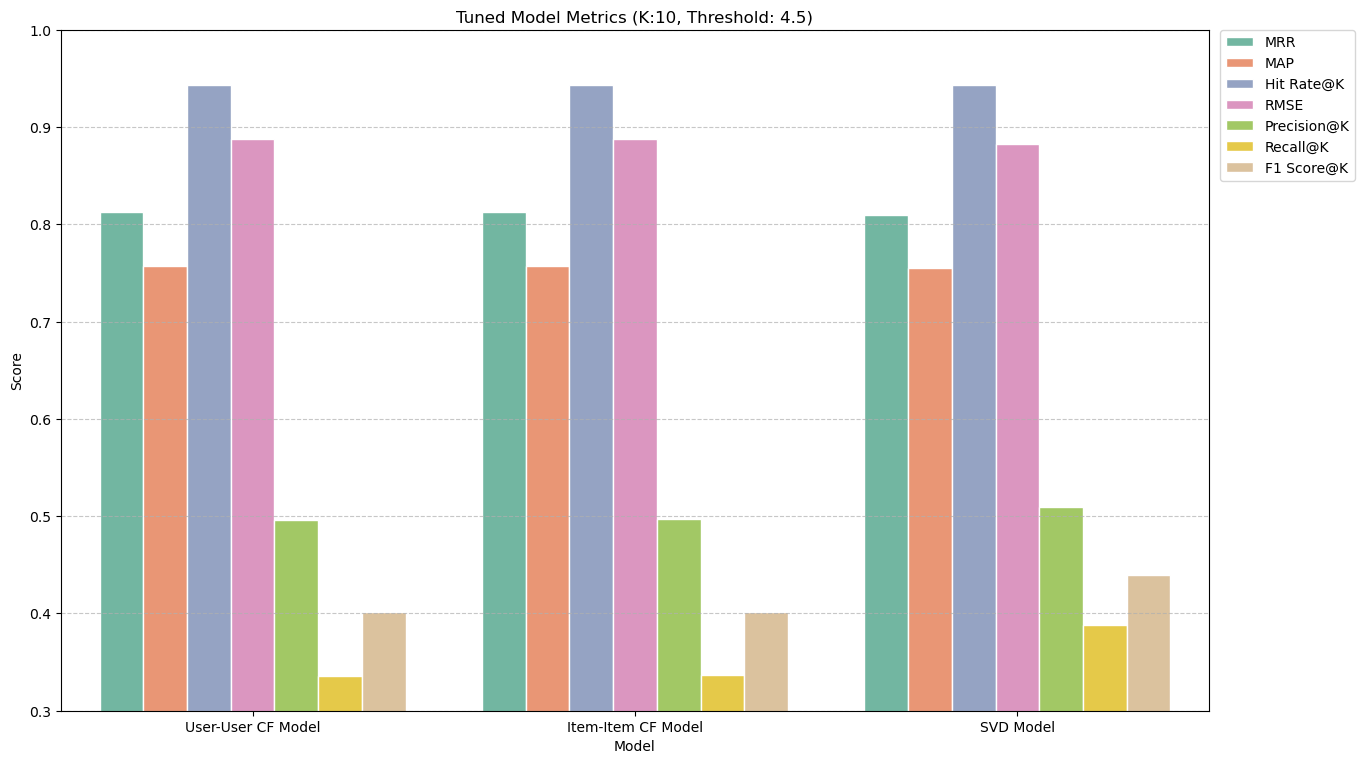

In [61]:
# Note: model_uu: User-User CF Model, model_ii: Item-Item CF Model, model_svd: SVD Model

# Dictionary of tuned model and their corresponding metrics
metrics = {
    "Rank Model": model_rank_metric[1],
    "User-User CF Model": model_uu_opt_metric[1],
    "Item-Item CF Model": model_ii_opt_metric[1],
    "SVD Model": model_svd_opt_metric[1],
    "Hybrid Model": hybrid_metric[1],
}

# Generate algorithm names dynamically
algo_names = [
    algo.algo_name for algo in [model_rank, model_uu, model_ii, model_svd, model_hybrid]
]

# Display DataFrames
prepare_and_display_metrics(metrics, algo_names, "Tuned Models Metrics")

# Convert the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics).T

# Melt the DataFrame to a long format suitable for Seaborn
metrics_df.reset_index(inplace=True)
metrics_long = pd.melt(
    metrics_df, id_vars="index", var_name="Metric", value_name="Score"
)

# Rename columns for clarity
metrics_long.columns = ["Model", "Metric", "Score"]

# Plot using Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(
    x="Model",
    y="Score",
    hue="Metric",
    palette=palette_color,
    data=metrics_long,
    edgecolor="white",
)

# Improve the legend by placing it outside the plot
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)

# Add a title and grid
plt.title(f"Tuned Model Metrics (K:{k}, Threshold: {threshold})")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(0.2, 1)

# Adjust layout and show the plot
plt.tight_layout(pad=2.0)
plt.show()

### Export of Tuned Model

In [62]:
# Prepare full dataset in Surprise format
full_data = Dataset.load_from_df(df[["user_id", "prod_id", "rating"]], reader)
full_trainset = full_data.build_full_trainset()

# Initialize the best model with tuned parameters
final_model = model_svd.model
# final_model = copy.deepcopy(model_svd.model)

# Retrain the model on the full dataset
final_model.fit(full_trainset)

# Define the export path and filename
filename = "../models/final_model_svd.pkl"

# Export the final trained model
with open(filename, "wb") as f:
    pickle.dump(final_model, f)

# Print status log
print(f"Parameters: {model_svd.best_params}")
print(f"Tuned model exported successfully to '{filename}'")

Parameters: {'n_epochs': 55, 'lr_all': 0.003, 'reg_all': 0.22, 'n_factors': 20}
Tuned model exported successfully to '../models/final_model_svd.pkl'


In [63]:
# End the timer at the end of the notebook
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time in a readable format
print(f"Notebook runtime: {elapsed_time:.2f} seconds")
print(f"Notebook runtime: {(elapsed_time/60):.2f} minutes")

Notebook runtime: 1488.63 seconds
Notebook runtime: 24.81 minutes


## Conclusion and Recommendations